# Preprocessing Techniques for Spectrograms

SciPy seems to have one of the most popular spectrogram generators,
it's documentation is found
[here]("https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.spectrogram.html").

SciPy also has a tool for reading .wav files found
[here]("https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html#scipy.io.wavfile.read").

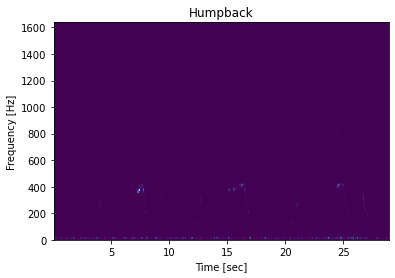

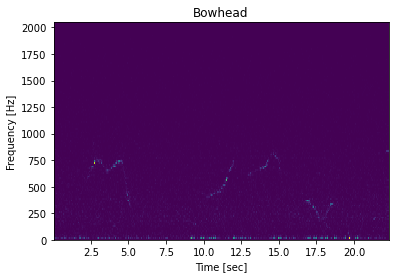

In [8]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

def plot_spectrogram(wav_file, spectrogram_title):
    """
    Plots a spectrogram of wav_file with title spectrogram_title
    :param wav_file: The .wav file to be plotted
    :param spectrogram_title: The title of the spectrogram to be plotted
    :return: a 2d ndarray of float32s which represents the spectrogram
    """
    sample_rate, samples = wavfile.read(wav_file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    plt.pcolormesh(times, frequencies, spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(spectrogram_title)
    plt.show()

    return spectrogram

humpback = plot_spectrogram('AU-AWBS04-141026-145051-40-DLW-humpback.wav', "Humpback")
bowhead = plot_spectrogram('AU-AWBF02-121025-010844-30-MAW-bowhead-song.wav', "Bowhead")

The bowhead call can be seen clearly in the above plot as the *M* shaped curves. The humpback's calls do not
stand out as readily, but are still visible especially in frequencies >400 Hz.

### Edge detection for cleaning data
From the above spectrogram, it seems possible that edge detection could be used to amplify
the call features.

Using
[canny edge detection]("https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html")

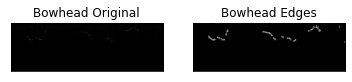

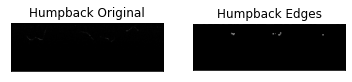

In [36]:
import cv2
import numpy as np

def edge_find(image, image_name):
    """
    Generates an edge-detected image of 'image'
    :param image: an ndarray as returned by plot_spectrogram
    :param image_name: The image title for image
    :return: None
    """
    # Preprocess to correct format for opencv's library
    image = image * (255.0 / image.max().item())
    image = image.astype(np.uint8)

    # Hysteresis thresholds are hand-picked and probably suboptimal
    edges = cv2.Canny(image,25,95)

    plt.subplot(121),plt.imshow(bowhead,cmap = 'gray')
    plt.title('{} Original'.format(image_name)), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('{} Edges'.format(image_name)), plt.xticks([]), plt.yticks([])

    plt.show()

edge_find(bowhead, "Bowhead")
edge_find(humpback, "Humpback")